In [15]:
import db
import networkx as nx
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

In [16]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@11/"

In [17]:
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark

findspark.init("./spark-3.2.0-bin-hadoop3.2")

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [18]:
connection = db.connect()
cursor = connection.cursor()

In [19]:
cursor.execute("""
    SELECT d1.officer_id src, d2.officer_id dst, COUNT(*) shifts_worked
    FROM data_officerassignmentattendance d1
        JOIN data_officerassignmentattendance d2 
        ON d1.start_timestamp = d2.start_timestamp 
            AND d1.beat_id = d2.beat_id 
            AND d1.officer_id < d2.officer_id
    WHERE d1.present_for_duty AND d2.present_for_duty
    GROUP BY d1.officer_id, d2.officer_id;
""")
tsedges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [20]:
tsedges

,src,dst,shifts_worked
0,1,157,2
1,1,916,6
2,1,997,1
3,1,1199,2
4,1,1548,1
...,...,...,...
432744,35546,35548,30
432745,35546,35550,29
432746,35547,35548,25
432747,35547,35550,26


In [21]:
cursor.execute("""
    SELECT t1.officer_id src, t2.officer_id dst, COUNT(DISTINCT t1.event_id)
    FROM trr_trr t1 JOIN trr_trr t2 ON t1.event_id = t2.event_id AND t1.officer_id < t2.officer_id
    GROUP BY t1.officer_id, t2.officer_id
    ORDER BY count(DISTINCT t1.event_id) DESC;
""")
edges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [22]:
edges

,src,dst,count
0,31795,32105,24
1,2798,31576,20
2,17634,29992,18
3,1444,29209,16
4,27669,29670,16
...,...,...,...
29382,1927,16115,1
29383,1927,16265,1
29384,1927,21210,1
29385,1927,23774,1


In [23]:
edges_reverse = edges.copy(deep=True)
edges_reverse['tmp'] = edges_reverse['src']
edges_reverse['src'] = edges_reverse['dst']
edges_reverse['dst'] = edges_reverse['tmp']
edges_reverse = edges_reverse.drop(columns=['tmp'])
edges_reverse

,src,dst,count
0,32105,31795,24
1,31576,2798,20
2,29992,17634,18
3,29209,1444,16
4,29670,27669,16
...,...,...,...
29382,16115,1927,1
29383,16265,1927,1
29384,21210,1927,1
29385,23774,1927,1


In [24]:
aedges = pd.concat([edges, edges_reverse])
aedges

,src,dst,count
0,31795,32105,24
1,2798,31576,20
2,17634,29992,18
3,1444,29209,16
4,27669,29670,16
...,...,...,...
29382,16115,1927,1
29383,16265,1927,1
29384,21210,1927,1
29385,23774,1927,1


In [25]:
cursor.execute("""
    SELECT  id, first_name || ' ' || last_name "name", trr_count
    FROM data_officer
    WHERE id IN (SELECT DISTINCT  officer_id FROM trr_trr);
""")
nodes = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [26]:
nodes

,id,name,trr_count
0,32312,Randall Ryan,4
1,32358,Kevin Stoll,5
2,32461,Albert Krueger,1
3,15636,Marie Lane,1
4,31793,Adam Aleszczyk,4
...,...,...,...
10793,32398,Thomas Waldera,1
10794,32098,Christoph Kennedy,2
10795,25503,Christ Savickas,7
10796,25732,Andrew Schoeff,1


In [274]:
pr = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(aedges),
).pageRank(resetProbability=0.15, tol=0.01)
pr.vertices.orderBy('pagerank', ascending=False).show()

+-----+-------------------+---------+-----------------+
|   id|               name|trr_count|         pagerank|
+-----+-------------------+---------+-----------------+
|10583|     George Granias|       72|8.032597730059983|
|21371|    Phillip Orlando|       41|7.571730383938765|
|32118|         Cesar Kuri|       65|6.822480218925139|
|14400|      Patrick Kelly|       62|6.303867803567349|
|28970|       Jeff Truhlar|       37|6.112292803559247|
|30091|   Takia Washington|       46|5.420885015731482|
|31030|         Lucas Wise|       53|5.386760743493899|
|14969|Daniel Kolodziejski|       53|5.113931457720295|
|32402|      Michael Walsh|       48|5.079307486222686|
| 8176|       Elmer Fabian|       44|5.060543269866183|
|12299|  Evangelos Hitiris|       41|5.046922077503595|
|13605|       Mark Johnson|       46|5.003785026688874|
|29670|     Adrian Vivanco|       64|4.994835741261612|
|13778|         Cory Jones|       45|4.977045443174628|
|20154|         Kevin Muth|       23|4.950292272

In [285]:
pr = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(edges),
).pageRank(resetProbability=0.15, tol=0.01)
pr.vertices.orderBy('pagerank', ascending=False).show()

+-----+------------------+---------+------------------+
|   id|              name|trr_count|          pagerank|
+-----+------------------+---------+------------------+
|32402|     Michael Walsh|       48| 38.52027608828122|
|32415|   Patrick Wherfel|       12|  38.0788643115646|
|32383|    Armando Ugarte|       31|35.662378779691394|
|32407|  Nathaniel Warner|        8| 34.55807670042016|
|32414|       Cassie West|       12|33.211919980496845|
|32438|      Nick Zarbock|       12|31.874870599589652|
|32307|    Zachary Rubald|       48|29.689146012847846|
|32142|        Jose Lopez|       20|26.734131335675926|
|32366|     Martin Teresi|       18|22.660277093859733|
|32420|     Raymond Wilke|       19| 21.99402260103985|
|32118|        Cesar Kuri|       65|20.372816566906017|
|32210|   Daniel Moynihan|       25|18.785628071302146|
|32357|     Kris Stipanov|       21|18.676566749881243|
|31980|     Robert Gallas|       26| 18.52625982000817|
|32375|James Triantafillo|       32|17.805350442

In [27]:
triangles = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(edges),
).triangleCount().toPandas()
triangles = triangles.sort_values(by=['count'], ascending=False)

In [28]:
triangles[:100]

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41
6969,182,13313,Steve Jarosz,20
6046,180,11615,Ryan Harty,22
6426,162,30561,Wayne Wiberg,30
10370,148,10583,George Granias,72
...,...,...,...,...
10364,63,5645,Daniel Cravens,38
8372,63,19866,Michael Mulcahy,12
3784,63,18872,Dominic Merola,26
8146,62,27084,Fernando Soto,12


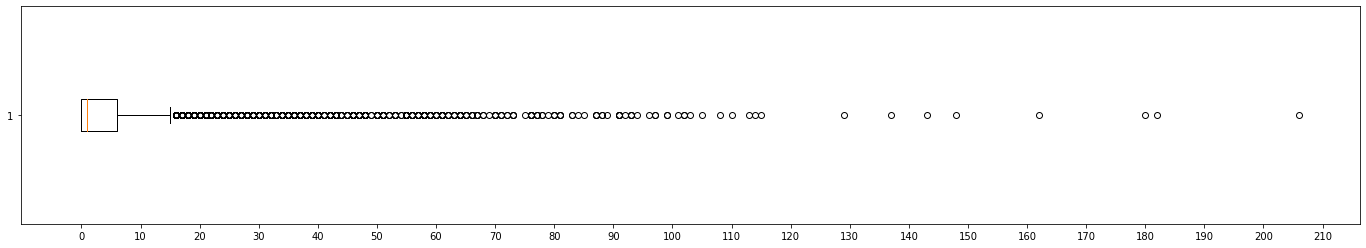

In [277]:
plt.figure(figsize=(24,4))
plt.boxplot(triangles['count'], vert=False)
plt.xticks(range(0,220,10))
plt.show()

In [213]:
triangle_ids = set(triangles[:100]['id'])
len(triangle_ids)

100

In [279]:
gfull = nx.from_pandas_edgelist(aedges, 'src', 'dst')

In [280]:
nx.average_clustering(gfull)

0.29707584853607866

In [281]:
gclustering = dict(sorted(nx.clustering(gfull).items(), key=lambda x: x[1], reverse=True))
gclustering

{20728: 1.0,
 26404: 1.0,
 4567: 1.0,
 19696: 1.0,
 34: 1.0,
 49: 1.0,
 19305: 1.0,
 3004: 1.0,
 7333: 1.0,
 21941: 1.0,
 25445: 1.0,
 8258: 1.0,
 10262: 1.0,
 1136: 1.0,
 6861: 1.0,
 22529: 1.0,
 24463: 1.0,
 2234: 1.0,
 16173: 1.0,
 26604: 1.0,
 5709: 1.0,
 21043: 1.0,
 23383: 1.0,
 9164: 1.0,
 24571: 1.0,
 32056: 1.0,
 10263: 1.0,
 26377: 1.0,
 31999: 1.0,
 21333: 1.0,
 22295: 1.0,
 7001: 1.0,
 30992: 1.0,
 15852: 1.0,
 1813: 1.0,
 7971: 1.0,
 20627: 1.0,
 2723: 1.0,
 23736: 1.0,
 29591: 1.0,
 19280: 1.0,
 32223: 1.0,
 3733: 1.0,
 13999: 1.0,
 25759: 1.0,
 197: 1.0,
 21022: 1.0,
 25529: 1.0,
 32234: 1.0,
 9528: 1.0,
 30987: 1.0,
 32038: 1.0,
 23363: 1.0,
 14103: 1.0,
 24679: 1.0,
 22729: 1.0,
 2269: 1.0,
 24647: 1.0,
 25243: 1.0,
 29002: 1.0,
 452: 1.0,
 24569: 1.0,
 17320: 1.0,
 29543: 1.0,
 3479: 1.0,
 23463: 1.0,
 406: 1.0,
 4225: 1.0,
 5100: 1.0,
 11019: 1.0,
 19109: 1.0,
 8624: 1.0,
 8621: 1.0,
 32436: 1.0,
 25355: 1.0,
 286: 1.0,
 29896: 1.0,
 11056: 1.0,
 16043: 1.0,
 23765: 

In [286]:
gclustering[10583]

0.06128364389233954

In [283]:
gtriangles = dict(sorted(nx.triangles(gfull).items(), key=lambda x: x[1], reverse=True))
gtriangles

{21371: 206,
 13313: 182,
 11615: 180,
 30561: 162,
 10583: 148,
 32118: 143,
 31337: 137,
 32271: 129,
 8374: 115,
 8628: 114,
 20154: 113,
 3558: 110,
 32175: 108,
 29454: 105,
 8138: 103,
 26018: 102,
 20860: 102,
 5204: 101,
 31576: 99,
 27900: 99,
 31795: 97,
 11129: 97,
 8349: 96,
 31030: 94,
 761: 93,
 32142: 93,
 31815: 93,
 29772: 92,
 32402: 91,
 12087: 91,
 13498: 91,
 14513: 91,
 29992: 89,
 17634: 88,
 16615: 88,
 14400: 87,
 17189: 87,
 262: 87,
 32357: 85,
 17259: 84,
 29767: 83,
 31381: 83,
 24695: 81,
 29517: 81,
 25169: 81,
 32141: 80,
 22140: 80,
 19564: 80,
 31164: 79,
 2110: 78,
 31948: 78,
 4295: 77,
 8842: 77,
 2671: 77,
 2798: 76,
 29670: 76,
 21596: 76,
 13873: 76,
 15811: 76,
 8485: 75,
 32052: 73,
 25789: 73,
 1696: 73,
 4187: 72,
 31127: 72,
 13605: 71,
 28970: 71,
 5957: 71,
 464: 70,
 22946: 70,
 12391: 70,
 24116: 70,
 21468: 69,
 32025: 68,
 2346: 68,
 31551: 67,
 32180: 67,
 29433: 67,
 24710: 67,
 25983: 66,
 32185: 66,
 11257: 66,
 1420: 66,
 32266: 6

In [287]:
gtriangles[10583]

148

In [30]:
triangles[:100]

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41
6969,182,13313,Steve Jarosz,20
6046,180,11615,Ryan Harty,22
6426,162,30561,Wayne Wiberg,30
10370,148,10583,George Granias,72
...,...,...,...,...
10364,63,5645,Daniel Cravens,38
8372,63,19866,Michael Mulcahy,12
3784,63,18872,Dominic Merola,26
8146,62,27084,Fernando Soto,12


In [56]:
interested = set(triangles[:50]['id'])

In [29]:
triangles[triangles['id'] == 10583]

,count,id,name,trr_count
10370,148,10583,George Granias,72


In [32]:
triangles[triangles['id'] == 21371]

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41


In [64]:
def plot_graph(edges):
    plt.figure(figsize=(30,20))
    g = nx.Graph()
    g = nx.from_pandas_edgelist(edges, 'src', 'dst')
    nx.draw(g, with_labels=False, arrows=False, node_color='grey', node_size=50)
    plt.show()

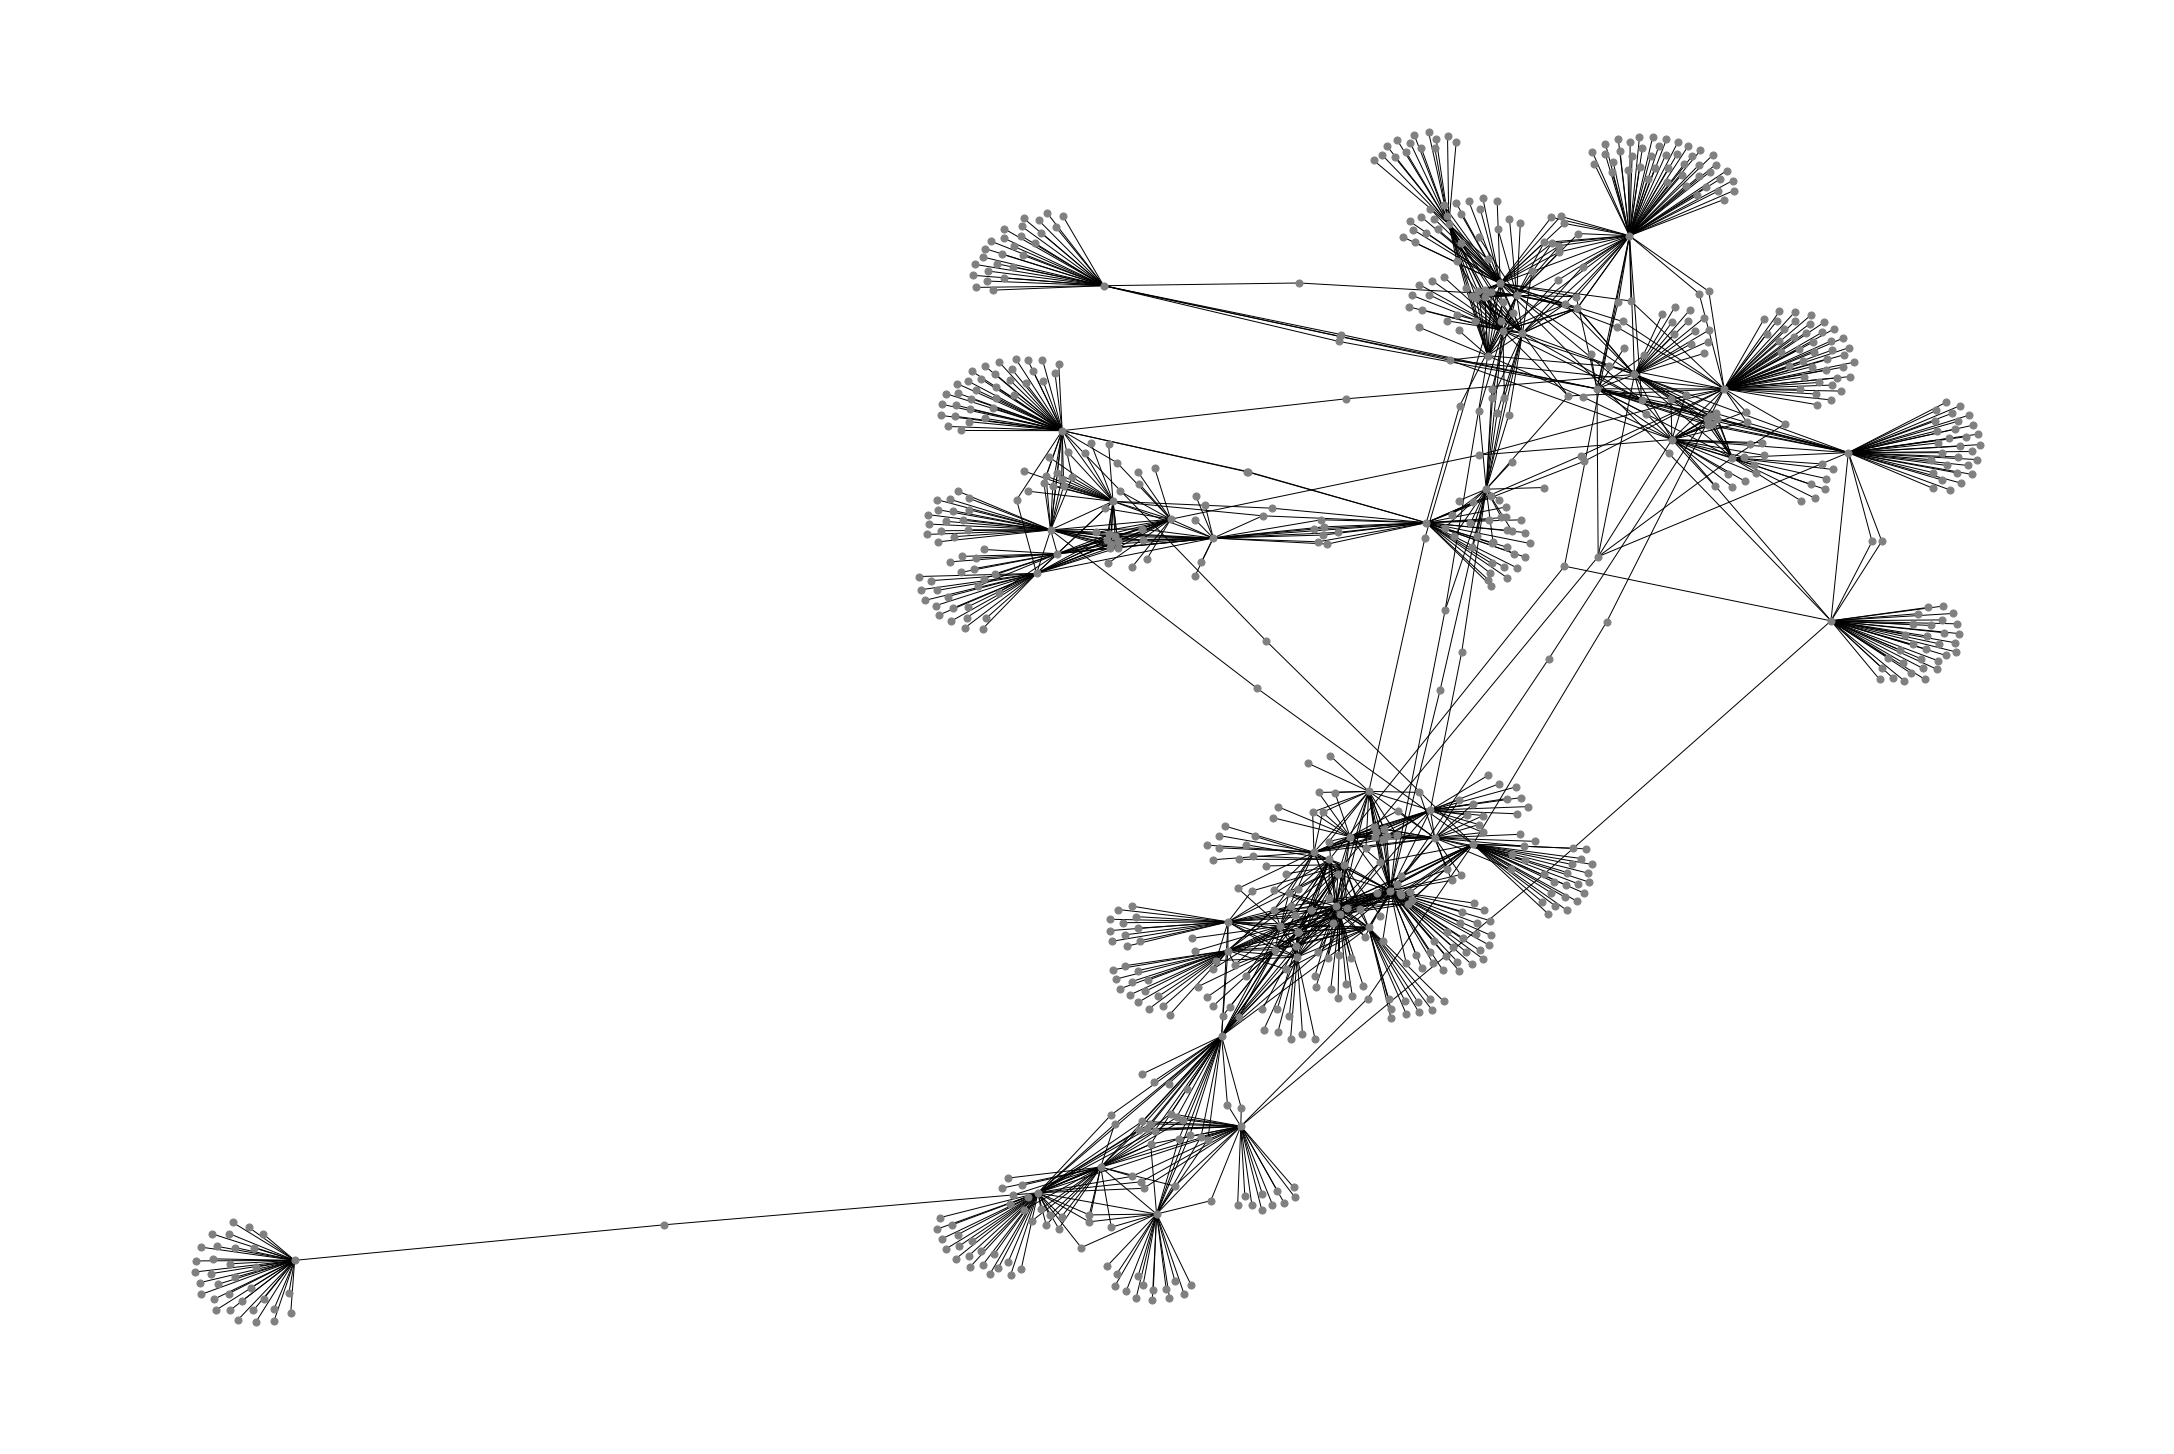

In [67]:
plot_graph(edges[(edges['src'].isin(interested)) | (edges['dst'].isin(interested))])

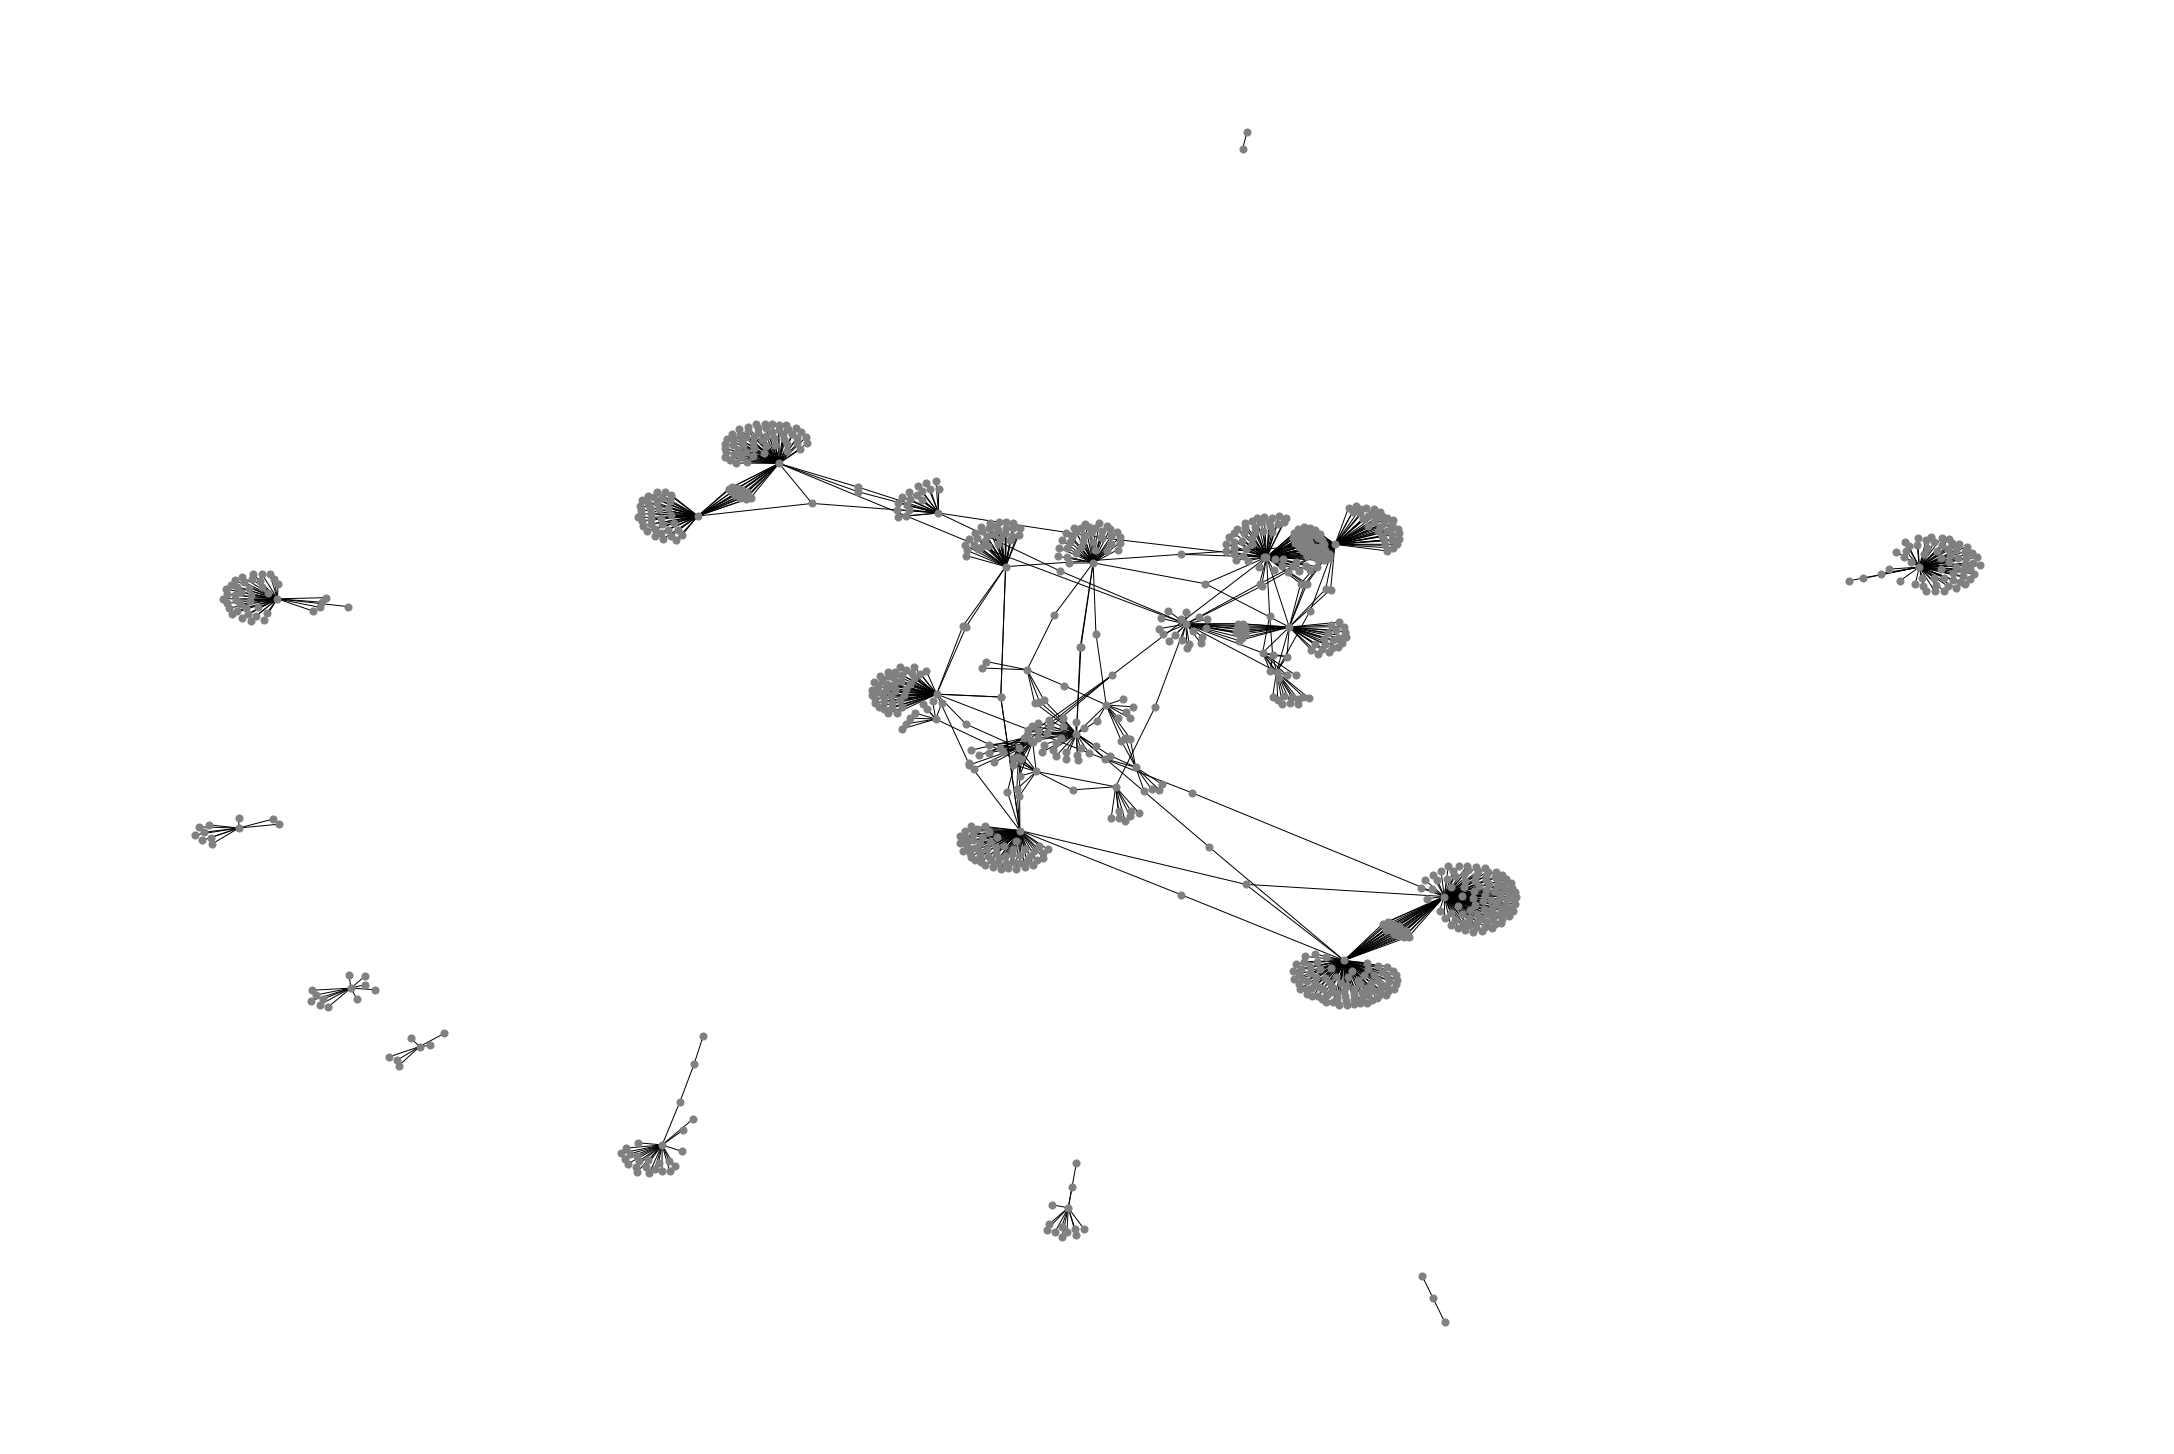

In [68]:
plot_graph(tsedges[(tsedges['src'].isin(interested)) | (tsedges['dst'].isin(interested))])